In [23]:
import torch

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [19]:
scaler = MinMaxScaler()

In [12]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [22]:
X=scaler.fit_transform(X)

In [2]:
torch.cuda.is_available()

True

In [24]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
df=np.concatenate((X,y.reshape(-1,1)),axis=1)

In [77]:
df.shape

(150, 5)

In [35]:
data=torch.tensor(df,device=device)

In [38]:
from torch.utils.data import random_split

In [39]:
train,test=random_split(data,[120,30])

In [41]:
train_loader=torch.utils.data.DataLoader(train,batch_size=15,shuffle=True)
test_loader=torch.utils.data.DataLoader(test,batch_size=15,shuffle=True)

In [42]:
from torch import nn
import torch.nn.functional as F

In [209]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        self.l1=nn.Linear(4,50)
        self.l2=nn.Linear(50,50)
        self.l3=nn.Linear(50,3)
        
    def forward(self,x):
        x=x.view(-1,4)
        x=F.relu(self.l1(x))
        x=F.relu(self.l2(x))
        x=F.softmax(self.l3(x),dim=1)
        return x
        
        
        

In [43]:
from torch import optim

In [185]:
import tqdm
n_epochs  = 3000

In [ ]:
###Logistic regression with SGD, not regularized
model=Net().to(device=device)

loss_f=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# to track the training loss as the model trains

# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_test_losses = [] 
    
# initialize the early_stopping object
es=0

for epoch in tqdm.trange(n_epochs):
    train_losses=[]
    test_losses=[]
    train_loss=0
    test_loss=0
    model.train()   
    for i in train_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        optimizer.zero_grad()
        outputs=model(inputs)
        #outputs1=torch.argmax(outputs, dim=1)
        loss=loss_f(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    #train_losses.append(train_loss)
    avg_train_losses.append(train_loss/8)
    
    model.eval()
    for i in test_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        outputs=model(inputs)
        loss=loss_f(outputs,labels)
        test_loss+=loss.item()
        correct = (torch.argmax(outputs, dim=1) == labels).type(torch.FloatTensor)
    #test_losses.append(test_loss)
    avg_test_losses.append(test_loss/2)
            

    print('Epoch: {} Train Loss: {} Test Loss {} Accuracy {}'.format(epoch,avg_train_losses[-1],avg_test_losses[-1],correct.mean()))

    if avg_test_losses[-1] > np.array(avg_test_losses).min():
        es +=1
    else:
        es=0
    
    if es >= 20:
        break

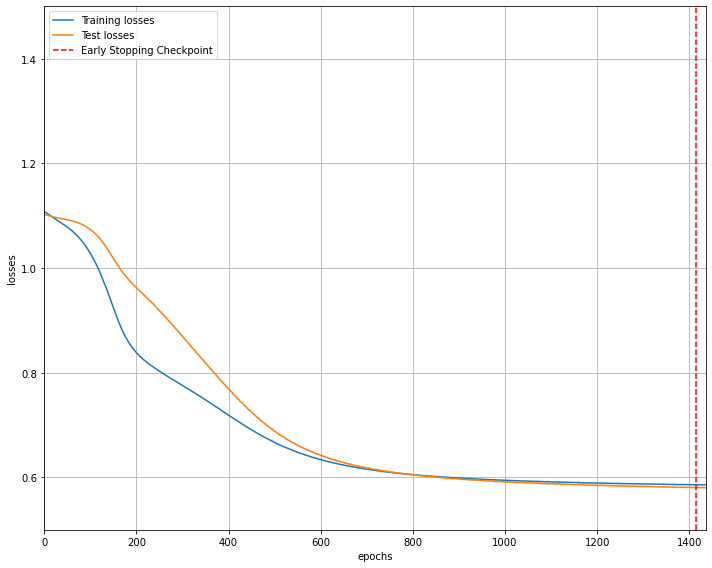

In [208]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training losses')
plt.plot(range(1,len(avg_test_losses)+1),avg_test_losses,label='Test losses')

# find position of lowest validation losses
minposs = avg_test_losses.index(min(avg_test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.ylim(0.5, 1.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('losses_plot.png', bbox_inches='tight')

In [ ]:
###Logistic regression with SGD-nesterov, not regularized

model=Net().to(device=device)

loss_f=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9,nesterov=True)
# to track the training loss as the model trains

# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_test_losses = [] 
    
# initialize the early_stopping object
es=0

for epoch in tqdm.trange(n_epochs):
    train_losses=[]
    test_losses=[]
    train_loss=0
    test_loss=0
    model.train()   
    for i in train_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        optimizer.zero_grad()
        outputs=model(inputs)
        #outputs1=torch.argmax(outputs, dim=1)
        loss=loss_f(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    #train_losses.append(train_loss)
    avg_train_losses.append(train_loss/8)
    
    model.eval()
    for i in test_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        outputs=model(inputs)
        loss=loss_f(outputs,labels)
        test_loss+=loss.item()
        correct = (torch.argmax(outputs, dim=1) == labels).type(torch.FloatTensor)
    #test_losses.append(test_loss)
    avg_test_losses.append(test_loss/2)
            

    print('Epoch: {} Train Loss: {} Test Loss {} Accuracy {}'.format(epoch,avg_train_losses[-1],avg_test_losses[-1],correct.mean()))

    if avg_test_losses[-1] > np.array(avg_test_losses).min():
        es +=1
    else:
        es=0
    
    if es >= 20:
        break

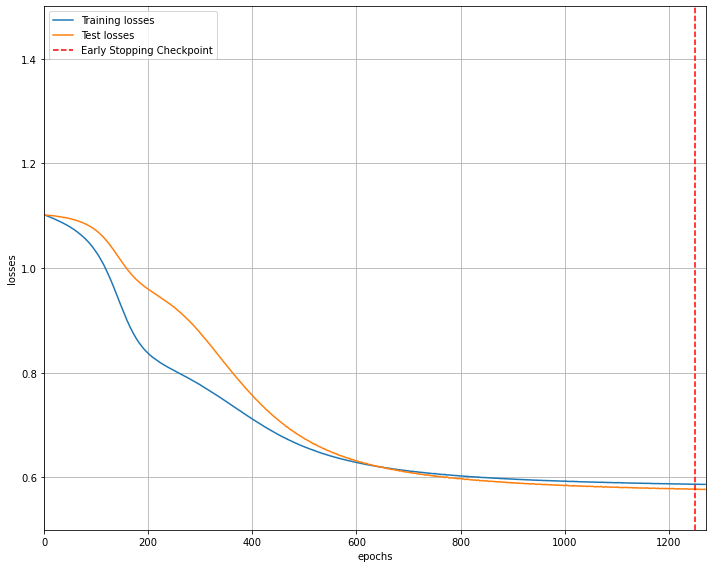

In [215]:
## converged a bit faster than SGD without Nesterov
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training losses')
plt.plot(range(1,len(avg_test_losses)+1),avg_test_losses,label='Test losses')

# find position of lowest validation losses
minposs = avg_test_losses.index(min(avg_test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.ylim(0.5, 1.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('losses_plot.png', bbox_inches='tight')

In [218]:
###Logistic regression with Adam, not regularized

model=Net().to(device=device)

loss_f=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)
# to track the training loss as the model trains

# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_test_losses = [] 
    
# initialize the early_stopping object
es=0

for epoch in tqdm.trange(n_epochs):
    train_losses=[]
    test_losses=[]
    train_loss=0
    test_loss=0
    model.train()   
    for i in train_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        optimizer.zero_grad()
        outputs=model(inputs)
        #outputs1=torch.argmax(outputs, dim=1)
        loss=loss_f(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    #train_losses.append(train_loss)
    avg_train_losses.append(train_loss/8)
    
    model.eval()
    for i in test_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        outputs=model(inputs)
        loss=loss_f(outputs,labels)
        test_loss+=loss.item()
        correct = (torch.argmax(outputs, dim=1) == labels).type(torch.FloatTensor)
    #test_losses.append(test_loss)
    avg_test_losses.append(test_loss/2)
            

    print('Epoch: {} Train Loss: {} Test Loss {} Accuracy {}'.format(epoch,avg_train_losses[-1],avg_test_losses[-1],correct.mean()))

    if avg_test_losses[-1] > np.array(avg_test_losses).min():
        es +=1
    else:
        es=0
    
    if es >= 20:
        break

  0%|          | 7/3000 [00:00<00:49, 60.87it/s]

Epoch: 0 Train Loss: 1.0877163112163544 Test Loss 1.0967795848846436 Accuracy 0.46666666865348816
Epoch: 1 Train Loss: 1.076001912355423 Test Loss 1.0898455381393433 Accuracy 0.46666666865348816
Epoch: 2 Train Loss: 1.0650357902050018 Test Loss 1.0825604796409607 Accuracy 0.5333333611488342
Epoch: 3 Train Loss: 1.0505624264478683 Test Loss 1.0745424628257751 Accuracy 0.5333333611488342
Epoch: 4 Train Loss: 1.0348328724503517 Test Loss 1.0655136704444885 Accuracy 0.46666666865348816
Epoch: 5 Train Loss: 1.0130970403552055 Test Loss 1.0523300766944885 Accuracy 0.6666666865348816
Epoch: 6 Train Loss: 0.9884872734546661 Test Loss 1.0363707542419434 Accuracy 0.5333333611488342
Epoch: 7 Train Loss: 0.9593516141176224 Test Loss 1.0178468227386475 Accuracy 0.5333333611488342
Epoch: 8 Train Loss: 0.9265298917889595 Test Loss 0.9992561042308807 Accuracy 0.4000000059604645
Epoch: 9 Train Loss: 0.8932701423764229 Test Loss 0.9826212525367737 Accuracy 0.46666666865348816
Epoch: 10 Train Loss: 0.864

  1%|          | 21/3000 [00:00<00:46, 64.50it/s]

Epoch: 13 Train Loss: 0.8132442384958267 Test Loss 0.9243671894073486 Accuracy 0.5333333611488342
Epoch: 14 Train Loss: 0.8016232028603554 Test Loss 0.9078232645988464 Accuracy 0.6666666865348816
Epoch: 15 Train Loss: 0.7910741493105888 Test Loss 0.8884411752223969 Accuracy 0.46666666865348816
Epoch: 16 Train Loss: 0.7803662195801735 Test Loss 0.865265429019928 Accuracy 0.6000000238418579
Epoch: 17 Train Loss: 0.7700829282402992 Test Loss 0.8404643535614014 Accuracy 0.5333333611488342
Epoch: 18 Train Loss: 0.7606183439493179 Test Loss 0.8256163895130157 Accuracy 0.7333333492279053
Epoch: 19 Train Loss: 0.7488578781485558 Test Loss 0.79971644282341 Accuracy 0.9333333373069763
Epoch: 20 Train Loss: 0.7383814007043839 Test Loss 0.7803725898265839 Accuracy 1.0
Epoch: 21 Train Loss: 0.7271010354161263 Test Loss 0.7690375447273254 Accuracy 0.800000011920929
Epoch: 22 Train Loss: 0.7169109806418419 Test Loss 0.747851550579071 Accuracy 0.9333333373069763
Epoch: 23 Train Loss: 0.706854455173015

  1%|          | 35/3000 [00:00<00:46, 63.67it/s]

Epoch: 26 Train Loss: 0.6783860102295876 Test Loss 0.696955680847168 Accuracy 0.9333333373069763
Epoch: 27 Train Loss: 0.6709268167614937 Test Loss 0.6799544095993042 Accuracy 1.0
Epoch: 28 Train Loss: 0.6633894294500351 Test Loss 0.6724838018417358 Accuracy 0.9333333373069763
Epoch: 29 Train Loss: 0.6568612307310104 Test Loss 0.6651500761508942 Accuracy 1.0
Epoch: 30 Train Loss: 0.6508332788944244 Test Loss 0.6590472757816315 Accuracy 1.0
Epoch: 31 Train Loss: 0.6486818268895149 Test Loss 0.6478042006492615 Accuracy 0.9333333373069763
Epoch: 32 Train Loss: 0.6406258046627045 Test Loss 0.6484791040420532 Accuracy 0.9333333373069763
Epoch: 33 Train Loss: 0.6365986838936806 Test Loss 0.638616293668747 Accuracy 1.0
Epoch: 34 Train Loss: 0.632550448179245 Test Loss 0.6334173083305359 Accuracy 1.0
Epoch: 35 Train Loss: 0.628649465739727 Test Loss 0.6292969584465027 Accuracy 0.9333333373069763
Epoch: 36 Train Loss: 0.6261163875460625 Test Loss 0.6254583299160004 Accuracy 0.9333333373069763
E

  2%|▏         | 51/3000 [00:00<00:43, 68.14it/s]

Epoch: 40 Train Loss: 0.6172554045915604 Test Loss 0.6140883564949036 Accuracy 0.9333333373069763
Epoch: 41 Train Loss: 0.6151126250624657 Test Loss 0.6089790761470795 Accuracy 1.0
Epoch: 42 Train Loss: 0.612268477678299 Test Loss 0.6151201725006104 Accuracy 0.9333333373069763
Epoch: 43 Train Loss: 0.6105109080672264 Test Loss 0.6079870760440826 Accuracy 0.9333333373069763
Epoch: 44 Train Loss: 0.6094096899032593 Test Loss 0.605815052986145 Accuracy 0.9333333373069763
Epoch: 45 Train Loss: 0.6075745299458504 Test Loss 0.6058759093284607 Accuracy 0.9333333373069763
Epoch: 46 Train Loss: 0.6060699820518494 Test Loss 0.6045909523963928 Accuracy 0.9333333373069763
Epoch: 47 Train Loss: 0.6045219078660011 Test Loss 0.6006039679050446 Accuracy 1.0
Epoch: 48 Train Loss: 0.6034371703863144 Test Loss 0.5994974076747894 Accuracy 0.9333333373069763
Epoch: 49 Train Loss: 0.6040468662977219 Test Loss 0.6012453734874725 Accuracy 1.0
Epoch: 50 Train Loss: 0.6039068624377251 Test Loss 0.59520703554153

  2%|▏         | 67/3000 [00:00<00:41, 70.41it/s]

Epoch: 55 Train Loss: 0.5972227528691292 Test Loss 0.5924448072910309 Accuracy 1.0
Epoch: 56 Train Loss: 0.5965137183666229 Test Loss 0.593027651309967 Accuracy 1.0
Epoch: 57 Train Loss: 0.5957160368561745 Test Loss 0.5945055484771729 Accuracy 1.0
Epoch: 58 Train Loss: 0.5959557071328163 Test Loss 0.5919274389743805 Accuracy 0.9333333373069763
Epoch: 59 Train Loss: 0.5951352715492249 Test Loss 0.5899914801120758 Accuracy 0.9333333373069763
Epoch: 60 Train Loss: 0.5941901281476021 Test Loss 0.589961588382721 Accuracy 1.0
Epoch: 61 Train Loss: 0.5949224233627319 Test Loss 0.5936773121356964 Accuracy 0.9333333373069763
Epoch: 62 Train Loss: 0.5938710570335388 Test Loss 0.5884004235267639 Accuracy 1.0
Epoch: 63 Train Loss: 0.595118448138237 Test Loss 0.5920465886592865 Accuracy 0.9333333373069763
Epoch: 64 Train Loss: 0.5912307053804398 Test Loss 0.586518794298172 Accuracy 0.9333333373069763
Epoch: 65 Train Loss: 0.5930294468998909 Test Loss 0.5853074491024017 Accuracy 0.9333333373069763
E

  3%|▎         | 82/3000 [00:01<00:43, 66.99it/s]

Epoch: 70 Train Loss: 0.5901275798678398 Test Loss 0.5856931209564209 Accuracy 0.9333333373069763
Epoch: 71 Train Loss: 0.5901764333248138 Test Loss 0.5843727290630341 Accuracy 0.9333333373069763
Epoch: 72 Train Loss: 0.591727152466774 Test Loss 0.5869307816028595 Accuracy 1.0
Epoch: 73 Train Loss: 0.5886465236544609 Test Loss 0.5837917625904083 Accuracy 1.0
Epoch: 74 Train Loss: 0.5922991409897804 Test Loss 0.5821941792964935 Accuracy 0.9333333373069763
Epoch: 75 Train Loss: 0.5878007933497429 Test Loss 0.5883430540561676 Accuracy 1.0
Epoch: 76 Train Loss: 0.5903075784444809 Test Loss 0.5880221128463745 Accuracy 0.9333333373069763
Epoch: 77 Train Loss: 0.5927975624799728 Test Loss 0.5809747874736786 Accuracy 0.9333333373069763
Epoch: 78 Train Loss: 0.5880966633558273 Test Loss 0.5853299796581268 Accuracy 1.0
Epoch: 79 Train Loss: 0.588116466999054 Test Loss 0.5862849056720734 Accuracy 1.0
Epoch: 80 Train Loss: 0.587680958211422 Test Loss 0.5808082818984985 Accuracy 0.9333333373069763


  3%|▎         | 97/3000 [00:01<00:42, 68.22it/s]

Epoch: 83 Train Loss: 0.5895595923066139 Test Loss 0.5886620581150055 Accuracy 0.9333333373069763
Epoch: 84 Train Loss: 0.58741594851017 Test Loss 0.5826106667518616 Accuracy 0.9333333373069763
Epoch: 85 Train Loss: 0.5893334299325943 Test Loss 0.5788019299507141 Accuracy 1.0
Epoch: 86 Train Loss: 0.5862372145056725 Test Loss 0.5819266438484192 Accuracy 0.9333333373069763
Epoch: 87 Train Loss: 0.5858875066041946 Test Loss 0.581917017698288 Accuracy 0.9333333373069763
Epoch: 88 Train Loss: 0.58604646474123 Test Loss 0.5801665484905243 Accuracy 0.9333333373069763
Epoch: 89 Train Loss: 0.5856836810708046 Test Loss 0.5804834067821503 Accuracy 1.0
Epoch: 90 Train Loss: 0.5873962566256523 Test Loss 0.5835356116294861 Accuracy 1.0
Epoch: 91 Train Loss: 0.5849888548254967 Test Loss 0.578654021024704 Accuracy 1.0
Epoch: 92 Train Loss: 0.5876238495111465 Test Loss 0.5797634422779083 Accuracy 0.9333333373069763
Epoch: 93 Train Loss: 0.585346408188343 Test Loss 0.5794739127159119 Accuracy 0.933333

  4%|▍         | 113/3000 [00:01<00:40, 70.72it/s]

Epoch: 98 Train Loss: 0.586764894425869 Test Loss 0.5856149196624756 Accuracy 0.9333333373069763
Epoch: 99 Train Loss: 0.5846238285303116 Test Loss 0.5783499479293823 Accuracy 1.0
Epoch: 100 Train Loss: 0.5839484110474586 Test Loss 0.5779498815536499 Accuracy 0.9333333373069763
Epoch: 101 Train Loss: 0.5836896076798439 Test Loss 0.5767881274223328 Accuracy 1.0
Epoch: 102 Train Loss: 0.5838374495506287 Test Loss 0.5776643753051758 Accuracy 1.0
Epoch: 103 Train Loss: 0.5858250111341476 Test Loss 0.581089437007904 Accuracy 1.0
Epoch: 104 Train Loss: 0.5850865244865417 Test Loss 0.5753231942653656 Accuracy 1.0
Epoch: 105 Train Loss: 0.5836232602596283 Test Loss 0.5764731168746948 Accuracy 1.0
Epoch: 106 Train Loss: 0.5834758952260017 Test Loss 0.5805297493934631 Accuracy 0.9333333373069763
Epoch: 107 Train Loss: 0.58359145373106 Test Loss 0.5781255960464478 Accuracy 1.0
Epoch: 108 Train Loss: 0.5834601372480392 Test Loss 0.5787277221679688 Accuracy 0.9333333373069763
Epoch: 109 Train Loss:

  4%|▍         | 121/3000 [00:01<00:41, 69.64it/s]

Epoch: 113 Train Loss: 0.5837785229086876 Test Loss 0.5755490064620972 Accuracy 0.9333333373069763
Epoch: 114 Train Loss: 0.5820720568299294 Test Loss 0.5772337317466736 Accuracy 0.9333333373069763
Epoch: 115 Train Loss: 0.583692379295826 Test Loss 0.5796960592269897 Accuracy 1.0
Epoch: 116 Train Loss: 0.5836887583136559 Test Loss 0.5753218233585358 Accuracy 0.9333333373069763
Epoch: 117 Train Loss: 0.5820712372660637 Test Loss 0.5759969055652618 Accuracy 1.0
Epoch: 118 Train Loss: 0.5820648446679115 Test Loss 0.5755432844161987 Accuracy 1.0
Epoch: 119 Train Loss: 0.583026185631752 Test Loss 0.5778988897800446 Accuracy 1.0
Epoch: 120 Train Loss: 0.5823327898979187 Test Loss 0.5743081867694855 Accuracy 0.9333333373069763
Epoch: 121 Train Loss: 0.5821354910731316 Test Loss 0.5756058692932129 Accuracy 1.0
Epoch: 122 Train Loss: 0.5818686112761497 Test Loss 0.5750276148319244 Accuracy 1.0
Epoch: 123 Train Loss: 0.5845348760485649 Test Loss 0.5730862319469452 Accuracy 0.9333333373069763
Epo

  5%|▍         | 136/3000 [00:02<00:41, 69.66it/s]

Epoch: 127 Train Loss: 0.581411562860012 Test Loss 0.576994776725769 Accuracy 1.0
Epoch: 128 Train Loss: 0.581949420273304 Test Loss 0.5768699645996094 Accuracy 1.0
Epoch: 129 Train Loss: 0.5811413824558258 Test Loss 0.5738406479358673 Accuracy 1.0
Epoch: 130 Train Loss: 0.5829119086265564 Test Loss 0.5732899904251099 Accuracy 0.9333333373069763
Epoch: 131 Train Loss: 0.5820198655128479 Test Loss 0.5768743455410004 Accuracy 0.9333333373069763
Epoch: 132 Train Loss: 0.5831822976469994 Test Loss 0.5737874507904053 Accuracy 1.0
Epoch: 133 Train Loss: 0.5808009430766106 Test Loss 0.5755676925182343 Accuracy 1.0
Epoch: 134 Train Loss: 0.5812651962041855 Test Loss 0.5757511854171753 Accuracy 1.0
Epoch: 135 Train Loss: 0.5811770707368851 Test Loss 0.5755850672721863 Accuracy 0.9333333373069763
Epoch: 136 Train Loss: 0.5857851579785347 Test Loss 0.5707001090049744 Accuracy 0.9333333373069763
Epoch: 137 Train Loss: 0.5801865234971046 Test Loss 0.5748777389526367 Accuracy 1.0
Epoch: 138 Train Lo

  5%|▌         | 150/3000 [00:02<00:41, 68.91it/s]

Epoch: 142 Train Loss: 0.5817767679691315 Test Loss 0.5739108026027679 Accuracy 0.9333333373069763
Epoch: 143 Train Loss: 0.5806848108768463 Test Loss 0.5742340683937073 Accuracy 0.9333333373069763
Epoch: 144 Train Loss: 0.5809440910816193 Test Loss 0.573485940694809 Accuracy 1.0
Epoch: 145 Train Loss: 0.5805657580494881 Test Loss 0.5725856125354767 Accuracy 1.0
Epoch: 146 Train Loss: 0.5809478238224983 Test Loss 0.5711355805397034 Accuracy 1.0
Epoch: 147 Train Loss: 0.5802147313952446 Test Loss 0.5726290643215179 Accuracy 1.0
Epoch: 148 Train Loss: 0.5804555267095566 Test Loss 0.5737610757350922 Accuracy 1.0
Epoch: 149 Train Loss: 0.5803644880652428 Test Loss 0.573596179485321 Accuracy 1.0
Epoch: 150 Train Loss: 0.5802027881145477 Test Loss 0.572741687297821 Accuracy 0.9333333373069763
Epoch: 151 Train Loss: 0.583101287484169 Test Loss 0.5691074430942535 Accuracy 1.0
Epoch: 152 Train Loss: 0.5792457088828087 Test Loss 0.5727379322052002 Accuracy 0.9333333373069763
Epoch: 153 Train Los

  5%|▌         | 164/3000 [00:02<00:42, 66.91it/s]

Epoch: 156 Train Loss: 0.5804719403386116 Test Loss 0.5710893869400024 Accuracy 0.9333333373069763
Epoch: 157 Train Loss: 0.5823573023080826 Test Loss 0.5694262981414795 Accuracy 0.9333333373069763
Epoch: 158 Train Loss: 0.5791656896471977 Test Loss 0.57426717877388 Accuracy 0.9333333373069763
Epoch: 159 Train Loss: 0.5800044983625412 Test Loss 0.574942409992218 Accuracy 1.0
Epoch: 160 Train Loss: 0.5803979635238647 Test Loss 0.572481095790863 Accuracy 1.0
Epoch: 161 Train Loss: 0.5798881724476814 Test Loss 0.5726012289524078 Accuracy 0.9333333373069763
Epoch: 162 Train Loss: 0.5789877250790596 Test Loss 0.5695700943470001 Accuracy 0.9333333373069763
Epoch: 163 Train Loss: 0.5806388035416603 Test Loss 0.5705187916755676 Accuracy 1.0
Epoch: 164 Train Loss: 0.580121785402298 Test Loss 0.5735486149787903 Accuracy 1.0
Epoch: 165 Train Loss: 0.5801286846399307 Test Loss 0.5703145563602448 Accuracy 0.9333333373069763
Epoch: 166 Train Loss: 0.5801437944173813 Test Loss 0.5704884827136993 Accu

  6%|▌         | 178/3000 [00:02<00:43, 64.51it/s]

Epoch: 169 Train Loss: 0.5828862413764 Test Loss 0.567383199930191 Accuracy 1.0
Epoch: 170 Train Loss: 0.5816894695162773 Test Loss 0.5748961269855499 Accuracy 0.9333333373069763
Epoch: 171 Train Loss: 0.5804524347186089 Test Loss 0.5726929306983948 Accuracy 1.0
Epoch: 172 Train Loss: 0.5790648013353348 Test Loss 0.5690248310565948 Accuracy 1.0
Epoch: 173 Train Loss: 0.5804105699062347 Test Loss 0.568535566329956 Accuracy 1.0
Epoch: 174 Train Loss: 0.5805609002709389 Test Loss 0.5765361785888672 Accuracy 0.9333333373069763
Epoch: 175 Train Loss: 0.5802092477679253 Test Loss 0.5737583339214325 Accuracy 0.9333333373069763
Epoch: 176 Train Loss: 0.5810204967856407 Test Loss 0.5680334866046906 Accuracy 1.0
Epoch: 177 Train Loss: 0.5790092796087265 Test Loss 0.5698870718479156 Accuracy 1.0
Epoch: 178 Train Loss: 0.5792804658412933 Test Loss 0.5724667310714722 Accuracy 1.0
Epoch: 179 Train Loss: 0.5799511447548866 Test Loss 0.5737884044647217 Accuracy 0.9333333373069763
Epoch: 180 Train Loss

  6%|▋         | 189/3000 [00:02<00:41, 67.00it/s]

Epoch: 183 Train Loss: 0.5801373794674873 Test Loss 0.569379448890686 Accuracy 1.0
Epoch: 184 Train Loss: 0.5789088234305382 Test Loss 0.5683617293834686 Accuracy 1.0
Epoch: 185 Train Loss: 0.5783899575471878 Test Loss 0.5689509809017181 Accuracy 1.0
Epoch: 186 Train Loss: 0.5781899616122246 Test Loss 0.5704872012138367 Accuracy 0.9333333373069763
Epoch: 187 Train Loss: 0.5789122134447098 Test Loss 0.5694828033447266 Accuracy 1.0
Epoch: 188 Train Loss: 0.5788262560963631 Test Loss 0.5697423219680786 Accuracy 1.0
Epoch: 189 Train Loss: 0.5785319432616234 Test Loss 0.5695532262325287 Accuracy 0.9333333373069763


In [ ]:
##Adam converged much faster than SGD

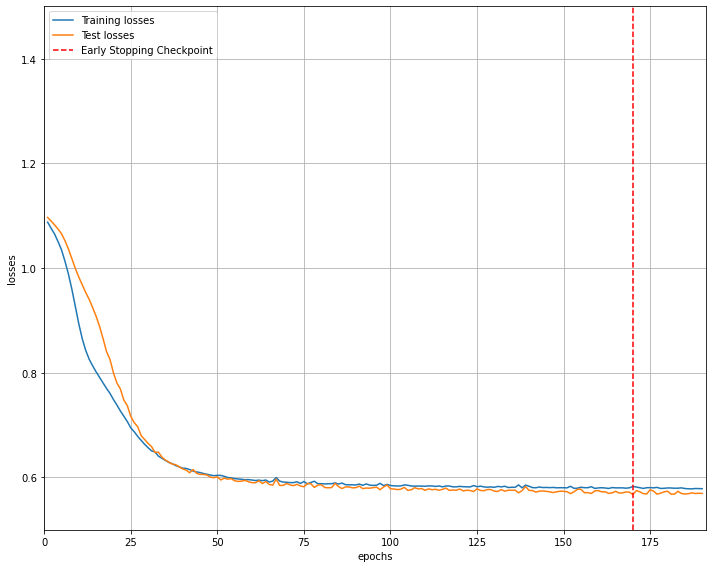

In [219]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training losses')
plt.plot(range(1,len(avg_test_losses)+1),avg_test_losses,label='Test losses')

# find position of lowest validation losses
minposs = avg_test_losses.index(min(avg_test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.ylim(0.5, 1.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('losses_plot.png', bbox_inches='tight')

In [220]:
###Logistic regression with ADAM,regularized

model=Net().to(device=device)

loss_f=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.01)
# to track the training loss as the model trains

# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_test_losses = [] 
    
# initialize the early_stopping object
es=0

for epoch in tqdm.trange(n_epochs):
    train_losses=[]
    test_losses=[]
    train_loss=0
    test_loss=0
    model.train()   
    for i in train_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        optimizer.zero_grad()
        outputs=model(inputs)
        #outputs1=torch.argmax(outputs, dim=1)
        loss=loss_f(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    #train_losses.append(train_loss)
    avg_train_losses.append(train_loss/8)
    
    model.eval()
    for i in test_loader:
        inputs,labels=torch.split(i,[4,1],dim=1)
        inputs=inputs.type(torch.FloatTensor).to(device=device)
        labels=labels.type(torch.LongTensor).to(device=device).reshape(15,)
        outputs=model(inputs)
        loss=loss_f(outputs,labels)
        test_loss+=loss.item()
        correct = (torch.argmax(outputs, dim=1) == labels).type(torch.FloatTensor)
    #test_losses.append(test_loss)
    avg_test_losses.append(test_loss/2)
            

    print('Epoch: {} Train Loss: {} Test Loss {} Accuracy {}'.format(epoch,avg_train_losses[-1],avg_test_losses[-1],correct.mean()))

    if avg_test_losses[-1] > np.array(avg_test_losses).min():
        es +=1
    else:
        es=0
    
    if es >= 20:
        break

  0%|          | 6/3000 [00:00<00:53, 55.53it/s]

Epoch: 0 Train Loss: 1.096011906862259 Test Loss 1.085058331489563 Accuracy 0.46666666865348816
Epoch: 1 Train Loss: 1.0868621915578842 Test Loss 1.0812139511108398 Accuracy 0.6000000238418579
Epoch: 2 Train Loss: 1.0797533988952637 Test Loss 1.0783461928367615 Accuracy 0.800000011920929
Epoch: 3 Train Loss: 1.0701721161603928 Test Loss 1.075002372264862 Accuracy 0.6000000238418579
Epoch: 4 Train Loss: 1.0604734420776367 Test Loss 1.0697829127311707 Accuracy 0.5333333611488342
Epoch: 5 Train Loss: 1.0489382445812225 Test Loss 1.0634589195251465 Accuracy 0.46666666865348816
Epoch: 6 Train Loss: 1.0353051573038101 Test Loss 1.0562447309494019 Accuracy 0.3333333432674408
Epoch: 7 Train Loss: 1.0177739337086678 Test Loss 1.0468450784683228 Accuracy 0.6000000238418579
Epoch: 8 Train Loss: 0.997571662068367 Test Loss 1.035503089427948 Accuracy 0.4000000059604645
Epoch: 9 Train Loss: 0.9752062410116196 Test Loss 1.0222628116607666 Accuracy 0.6000000238418579
Epoch: 10 Train Loss: 0.9480180442

  1%|          | 19/3000 [00:00<00:50, 58.89it/s]

Epoch: 12 Train Loss: 0.8948088064789772 Test Loss 0.9773735702037811 Accuracy 0.46666666865348816
Epoch: 13 Train Loss: 0.8715792596340179 Test Loss 0.9643285572528839 Accuracy 0.5333333611488342
Epoch: 14 Train Loss: 0.8522311374545097 Test Loss 0.9528146684169769 Accuracy 0.2666666805744171
Epoch: 15 Train Loss: 0.8371362388134003 Test Loss 0.9423239529132843 Accuracy 0.5333333611488342
Epoch: 16 Train Loss: 0.8259187415242195 Test Loss 0.9344464540481567 Accuracy 0.4000000059604645
Epoch: 17 Train Loss: 0.8174410313367844 Test Loss 0.9237929284572601 Accuracy 0.6000000238418579
Epoch: 18 Train Loss: 0.809992253780365 Test Loss 0.9147153794765472 Accuracy 0.5333333611488342
Epoch: 19 Train Loss: 0.8036524280905724 Test Loss 0.906502902507782 Accuracy 0.5333333611488342
Epoch: 20 Train Loss: 0.7982208207249641 Test Loss 0.8986120820045471 Accuracy 0.5333333611488342
Epoch: 21 Train Loss: 0.794214241206646 Test Loss 0.8873685002326965 Accuracy 0.5333333611488342
Epoch: 22 Train Loss: 

  1%|          | 33/3000 [00:00<00:48, 60.66it/s]

Epoch: 25 Train Loss: 0.773429811000824 Test Loss 0.8545847535133362 Accuracy 0.6000000238418579
Epoch: 26 Train Loss: 0.7679824754595757 Test Loss 0.8448111116886139 Accuracy 0.7333333492279053
Epoch: 27 Train Loss: 0.7646449208259583 Test Loss 0.830427497625351 Accuracy 0.7333333492279053
Epoch: 28 Train Loss: 0.7568984627723694 Test Loss 0.8247199058532715 Accuracy 0.9333333373069763
Epoch: 29 Train Loss: 0.7514501363039017 Test Loss 0.8176667392253876 Accuracy 0.800000011920929
Epoch: 30 Train Loss: 0.752144105732441 Test Loss 0.8021829724311829 Accuracy 0.9333333373069763
Epoch: 31 Train Loss: 0.743515782058239 Test Loss 0.803187370300293 Accuracy 0.7333333492279053
Epoch: 32 Train Loss: 0.7366079017519951 Test Loss 0.7902485132217407 Accuracy 0.9333333373069763
Epoch: 33 Train Loss: 0.7308627516031265 Test Loss 0.7811669707298279 Accuracy 0.9333333373069763
Epoch: 34 Train Loss: 0.7258106172084808 Test Loss 0.7733030617237091 Accuracy 0.9333333373069763
Epoch: 35 Train Loss: 0.72

  2%|▏         | 47/3000 [00:00<00:48, 61.36it/s]

Epoch: 38 Train Loss: 0.7062248513102531 Test Loss 0.7417370080947876 Accuracy 0.9333333373069763
Epoch: 39 Train Loss: 0.70180843770504 Test Loss 0.7373377680778503 Accuracy 1.0
Epoch: 40 Train Loss: 0.697575680911541 Test Loss 0.7323176562786102 Accuracy 1.0
Epoch: 41 Train Loss: 0.6938195526599884 Test Loss 0.7204757034778595 Accuracy 1.0
Epoch: 42 Train Loss: 0.6886459961533546 Test Loss 0.717867523431778 Accuracy 1.0
Epoch: 43 Train Loss: 0.6864606440067291 Test Loss 0.7127201557159424 Accuracy 0.9333333373069763
Epoch: 44 Train Loss: 0.6821097508072853 Test Loss 0.709299236536026 Accuracy 1.0
Epoch: 45 Train Loss: 0.6784500181674957 Test Loss 0.705706775188446 Accuracy 0.9333333373069763
Epoch: 46 Train Loss: 0.6754005029797554 Test Loss 0.6995761394500732 Accuracy 0.9333333373069763
Epoch: 47 Train Loss: 0.6741631478071213 Test Loss 0.6989284157752991 Accuracy 0.9333333373069763
Epoch: 48 Train Loss: 0.6707543507218361 Test Loss 0.6896515786647797 Accuracy 1.0
Epoch: 49 Train Lo

  2%|▏         | 61/3000 [00:01<00:48, 61.16it/s]

Epoch: 52 Train Loss: 0.664502739906311 Test Loss 0.6774705946445465 Accuracy 0.9333333373069763
Epoch: 53 Train Loss: 0.6652990281581879 Test Loss 0.6876312494277954 Accuracy 1.0
Epoch: 54 Train Loss: 0.6563968732953072 Test Loss 0.6723649501800537 Accuracy 1.0
Epoch: 55 Train Loss: 0.6584267988801003 Test Loss 0.671849936246872 Accuracy 0.9333333373069763
Epoch: 56 Train Loss: 0.6565286815166473 Test Loss 0.6756101846694946 Accuracy 0.9333333373069763
Epoch: 57 Train Loss: 0.6530716568231583 Test Loss 0.6687915921211243 Accuracy 0.9333333373069763
Epoch: 58 Train Loss: 0.6550805196166039 Test Loss 0.6660945117473602 Accuracy 1.0
Epoch: 59 Train Loss: 0.6519065871834755 Test Loss 0.672924667596817 Accuracy 0.9333333373069763
Epoch: 60 Train Loss: 0.6504681557416916 Test Loss 0.6655586659908295 Accuracy 0.9333333373069763
Epoch: 61 Train Loss: 0.6486445441842079 Test Loss 0.6610521376132965 Accuracy 0.9333333373069763
Epoch: 62 Train Loss: 0.6499756202101707 Test Loss 0.659092098474502

  2%|▎         | 75/3000 [00:01<00:48, 60.60it/s]

Epoch: 64 Train Loss: 0.6464468687772751 Test Loss 0.6586880683898926 Accuracy 1.0
Epoch: 65 Train Loss: 0.6490806564688683 Test Loss 0.657109409570694 Accuracy 1.0
Epoch: 66 Train Loss: 0.6464230641722679 Test Loss 0.6662004292011261 Accuracy 0.9333333373069763
Epoch: 67 Train Loss: 0.6450176164507866 Test Loss 0.6578650176525116 Accuracy 0.9333333373069763
Epoch: 68 Train Loss: 0.6438998952507973 Test Loss 0.654289722442627 Accuracy 1.0
Epoch: 69 Train Loss: 0.6434180960059166 Test Loss 0.6551200449466705 Accuracy 0.9333333373069763
Epoch: 70 Train Loss: 0.6432905569672585 Test Loss 0.6533488631248474 Accuracy 1.0
Epoch: 71 Train Loss: 0.6423982754349709 Test Loss 0.6549085676670074 Accuracy 0.9333333373069763
Epoch: 72 Train Loss: 0.6425344049930573 Test Loss 0.6525467336177826 Accuracy 0.9333333373069763
Epoch: 73 Train Loss: 0.6411260142922401 Test Loss 0.65323406457901 Accuracy 0.9333333373069763
Epoch: 74 Train Loss: 0.6411981582641602 Test Loss 0.6560692191123962 Accuracy 0.933

  3%|▎         | 90/3000 [00:01<00:44, 65.06it/s]

Epoch: 77 Train Loss: 0.6406050994992256 Test Loss 0.6495199501514435 Accuracy 1.0
Epoch: 78 Train Loss: 0.6400351449847221 Test Loss 0.6542710661888123 Accuracy 0.9333333373069763
Epoch: 79 Train Loss: 0.6412164121866226 Test Loss 0.6476985514163971 Accuracy 0.9333333373069763
Epoch: 80 Train Loss: 0.6393374428153038 Test Loss 0.6526789367198944 Accuracy 0.9333333373069763
Epoch: 81 Train Loss: 0.6383228600025177 Test Loss 0.6469663083553314 Accuracy 1.0
Epoch: 82 Train Loss: 0.638106994330883 Test Loss 0.6462898552417755 Accuracy 1.0
Epoch: 83 Train Loss: 0.6375017762184143 Test Loss 0.6483781039714813 Accuracy 0.9333333373069763
Epoch: 84 Train Loss: 0.6375947520136833 Test Loss 0.6503081917762756 Accuracy 0.9333333373069763
Epoch: 85 Train Loss: 0.6367461681365967 Test Loss 0.6463110744953156 Accuracy 1.0
Epoch: 86 Train Loss: 0.6370099261403084 Test Loss 0.6444185972213745 Accuracy 0.9333333373069763
Epoch: 87 Train Loss: 0.6373799666762352 Test Loss 0.6451878249645233 Accuracy 1.

  4%|▎         | 105/3000 [00:01<00:42, 68.20it/s]

Epoch: 92 Train Loss: 0.6354704946279526 Test Loss 0.6451691389083862 Accuracy 1.0
Epoch: 93 Train Loss: 0.6354748532176018 Test Loss 0.6424596011638641 Accuracy 0.9333333373069763
Epoch: 94 Train Loss: 0.6376447230577469 Test Loss 0.6516372263431549 Accuracy 0.9333333373069763
Epoch: 95 Train Loss: 0.6348882094025612 Test Loss 0.6435457766056061 Accuracy 1.0
Epoch: 96 Train Loss: 0.6348992213606834 Test Loss 0.6416855454444885 Accuracy 1.0
Epoch: 97 Train Loss: 0.6350516155362129 Test Loss 0.6442196369171143 Accuracy 1.0
Epoch: 98 Train Loss: 0.6346438303589821 Test Loss 0.6452542841434479 Accuracy 1.0
Epoch: 99 Train Loss: 0.6342481896281242 Test Loss 0.6428639888763428 Accuracy 0.9333333373069763
Epoch: 100 Train Loss: 0.6348524913191795 Test Loss 0.6437428295612335 Accuracy 0.9333333373069763
Epoch: 101 Train Loss: 0.6334715336561203 Test Loss 0.6413431763648987 Accuracy 1.0
Epoch: 102 Train Loss: 0.6338324919342995 Test Loss 0.6411347091197968 Accuracy 0.9333333373069763
Epoch: 10

  4%|▍         | 120/3000 [00:01<00:42, 67.81it/s]

Epoch: 107 Train Loss: 0.6336475536227226 Test Loss 0.6430360376834869 Accuracy 1.0
Epoch: 108 Train Loss: 0.6328680962324142 Test Loss 0.6418979167938232 Accuracy 1.0
Epoch: 109 Train Loss: 0.6338851600885391 Test Loss 0.6393493711948395 Accuracy 0.9333333373069763
Epoch: 110 Train Loss: 0.6327874660491943 Test Loss 0.6424959003925323 Accuracy 0.9333333373069763
Epoch: 111 Train Loss: 0.6322464570403099 Test Loss 0.6411303579807281 Accuracy 1.0
Epoch: 112 Train Loss: 0.6324726343154907 Test Loss 0.6389062404632568 Accuracy 0.9333333373069763
Epoch: 113 Train Loss: 0.6330282613635063 Test Loss 0.6426395773887634 Accuracy 1.0
Epoch: 114 Train Loss: 0.6319098547101021 Test Loss 0.6411517262458801 Accuracy 1.0
Epoch: 115 Train Loss: 0.632170170545578 Test Loss 0.6388708353042603 Accuracy 0.9333333373069763
Epoch: 116 Train Loss: 0.6356819197535515 Test Loss 0.6436586081981659 Accuracy 1.0
Epoch: 117 Train Loss: 0.6346546858549118 Test Loss 0.6356596648693085 Accuracy 0.9333333373069763
Ep

  4%|▍         | 134/3000 [00:02<00:42, 67.72it/s]

Epoch: 121 Train Loss: 0.6315828263759613 Test Loss 0.6403678953647614 Accuracy 0.9333333373069763
Epoch: 122 Train Loss: 0.6312636360526085 Test Loss 0.6391055285930634 Accuracy 0.9333333373069763
Epoch: 123 Train Loss: 0.6312182247638702 Test Loss 0.6401237845420837 Accuracy 1.0
Epoch: 124 Train Loss: 0.6313033252954483 Test Loss 0.6382495760917664 Accuracy 0.9333333373069763
Epoch: 125 Train Loss: 0.6311409696936607 Test Loss 0.6377851366996765 Accuracy 1.0
Epoch: 126 Train Loss: 0.6324102357029915 Test Loss 0.6401769518852234 Accuracy 0.9333333373069763
Epoch: 127 Train Loss: 0.6339691579341888 Test Loss 0.6354430317878723 Accuracy 1.0
Epoch: 128 Train Loss: 0.6319278702139854 Test Loss 0.6436525583267212 Accuracy 0.9333333373069763
Epoch: 129 Train Loss: 0.6317196637392044 Test Loss 0.6394904851913452 Accuracy 1.0
Epoch: 130 Train Loss: 0.6318791955709457 Test Loss 0.6359402537345886 Accuracy 1.0
Epoch: 131 Train Loss: 0.632457934319973 Test Loss 0.6430193185806274 Accuracy 1.0
Ep

  5%|▍         | 147/3000 [00:02<00:45, 63.09it/s]

Epoch: 135 Train Loss: 0.6303977146744728 Test Loss 0.6356931328773499 Accuracy 1.0
Epoch: 136 Train Loss: 0.6311977505683899 Test Loss 0.6355295777320862 Accuracy 1.0
Epoch: 137 Train Loss: 0.6318076997995377 Test Loss 0.6418961584568024 Accuracy 1.0
Epoch: 138 Train Loss: 0.6302987411618233 Test Loss 0.6373112499713898 Accuracy 0.9333333373069763
Epoch: 139 Train Loss: 0.6319201290607452 Test Loss 0.6359366476535797 Accuracy 0.9333333373069763
Epoch: 140 Train Loss: 0.6314999386668205 Test Loss 0.6429147720336914 Accuracy 1.0
Epoch: 141 Train Loss: 0.6334320157766342 Test Loss 0.6357054114341736 Accuracy 0.9333333373069763
Epoch: 142 Train Loss: 0.6298770383000374 Test Loss 0.6373744606971741 Accuracy 1.0
Epoch: 143 Train Loss: 0.6305792853236198 Test Loss 0.6386257708072662 Accuracy 1.0
Epoch: 144 Train Loss: 0.6304215863347054 Test Loss 0.64012211561203 Accuracy 0.9333333373069763
Epoch: 145 Train Loss: 0.6307480782270432 Test Loss 0.6358011066913605 Accuracy 1.0
Epoch: 146 Train L

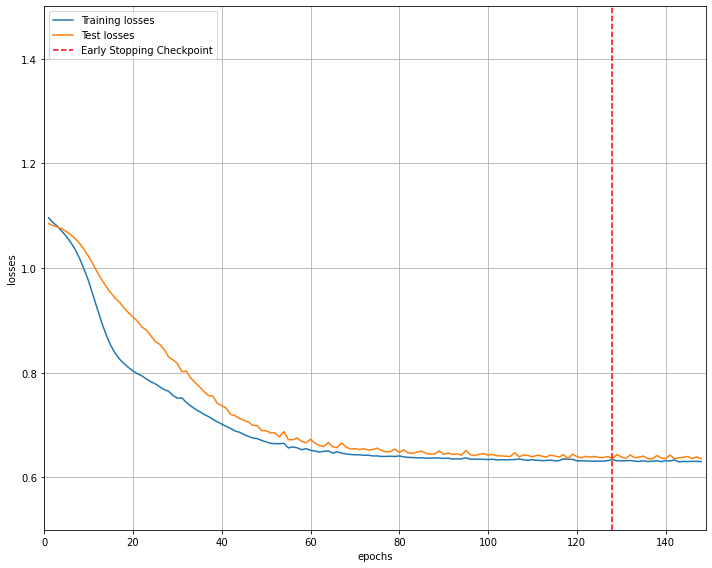

In [221]:
##Regularization did not cause change in accuracy probably because iris dataset is almost linearly seperable, also sample size might be too small to observe any significant change but it caused a bit faster convergence
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training losses')
plt.plot(range(1,len(avg_test_losses)+1),avg_test_losses,label='Test losses')

# find position of lowest validation losses
minposs = avg_test_losses.index(min(avg_test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.ylim(0.5, 1.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('losses_plot.png', bbox_inches='tight')